### Introduction
This project will test the attractiveness of various neighborhoods in the Manhattan NY area for the opening of CBD-retail focused stores.  The goal of the analysis is to identify 2-3 locations that would – before detailed boots-on-the-ground research – appear to support the opening of a CBD-Retail focused store.

The larger context is that now that CBD (via Hemp) is legal at a federal level in the United States, there is likely opportunity for entreprenuers to open up retail stores to sell CBD related products for either wellness or medical use.  Based on an article (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6043845/) we have statistically significant odds of usage of CBD products for medical needs.  Applying these odds to populations by zipcode in Manhattan NYC, we can determine good potential locations to open stores.

To rate neighborhood potential, we’ll base rankings on:

•	Usage Potential: we'll use the probabilities in the NIH report combined with census data to determine highest potential demand (usage potential) by zipcode, enabling us to stack-rank neighborhoods based on potential

•	Competition:  we'll look for neighborhoods that have the lowest density of existing pharmacies, as this would indicate competition for a CBD retail store that we might open

By blending population and neighborhood competition characteristics together we will be able to identify 2-3 locations where a CBD-retail store could be positioned to be successful.


### Import libraries and setup environment

In [37]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

import json # library to handle JSON files

print('Folium installed \n')
print('Libraries imported....on Oct 23rd - Morning \n')


Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Folium installed 

Libraries imported....on Oct 23rd - Morning 



In [1]:
#setup credentials for Foursquare
CLIENT_ID = 'NNN' # your Foursquare ID
CLIENT_SECRET = 'XXX' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NNN
CLIENT_SECRET:XXX


#### Data References
Link to source of Population Data: https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml

And how to download:  https://acsdatacommunity.prb.org/acs-data-products--resources/american-factfinder/f/3/t/330

The csv from the Census site contains population counts by age range, by zipcode.  For the purposes of this exercise, we've pulled data for the state of NY only.  For reference, here's a mapping of column names (see df_data_pop_1) to explanations of age ranges, which will be useful later on.

| Column Name | Decoder | 
| --- | --- |
|HC01_EST_VC01| Total population    |
|HC01_EST_VC08| AGE - 25 to 29 years|
|HC01_EST_VC09| AGE - 30 to 34 years|
|HC01_EST_VC10| AGE - 35 to 39 years|
|HC01_EST_VC11| AGE - 40 to 44 years|
|HC01_EST_VC12| AGE - 45 to 49 years|
|HC01_EST_VC13| AGE - 50 to 54 years|
|HC01_EST_VC14| AGE - 55 to 59 years|
|HC01_EST_VC15| AGE - 60 to 64 years|
|HC01_EST_VC16| AGE - 65 to 69 years|
|HC01_EST_VC17| AGE - 70 to 74 years|
|HC01_EST_VC18| AGE - 75 to 79 years|
|HC01_EST_VC19| AGE - 80 to 84 years|
|HC01_EST_VC20| AGE - 85 years and over|

As you can see in the census data layout, the age ranges are in 5 year "chunks".  In NIH the research linked above, the age ranges are in larger chunks of 10 years, so we'll want to do some manipulation of the data to get data grouped into the following age ranges:

| Range Name | Grouping | 
| --- | --- |
| Range 0 | Less than 24 |
| Range 1 | 25 - 34 |
| Range 2 | 35 - 44 |
| Range 3 | 45 - 54 |
| Range 4 | 55 - 64 |
| Range 5 | 65 - 74 |
| Range 6 | older than 75 |


In [3]:
#this is the code to load the data from the csv file included in this project, to a dataframe
import pandas as pd # library for data analsysis
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_2db08ba9a539447bac4d2169bcd11a6f = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='NNN',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_2db08ba9a539447bac4d2169bcd11a6f.get_object(Bucket='adscweek5project-donotdelete-pr-8s2szxgonfbsvj',Key='PopTableforloadingonly_CSV.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_pop_data_1 = pd.read_csv(body)
df_pop_data_1.head()


,GEO.id2,HC01_EST_VC01,HC01_EST_VC03,HC01_EST_VC04,HC01_EST_VC05,HC01_EST_VC06,HC01_EST_VC07,HC01_EST_VC08,HC01_EST_VC09,HC01_EST_VC10,HC01_EST_VC11,HC01_EST_VC12,HC01_EST_VC13,HC01_EST_VC14,HC01_EST_VC15,HC01_EST_VC16,HC01_EST_VC17,HC01_EST_VC18,HC01_EST_VC19,HC01_EST_VC20
0,10001,23947,622,893,832,1237,2524,2935,2747,1823,1682,1596,1320,1348,1437,1031,607,789,284,240
1,10002,77925,2827,2907,3007,3209,5037,8004,6601,5552,4586,5656,4944,4582,5276,3989,3760,2876,2317,2795
2,10003,55035,1846,797,593,7423,5037,8382,6007,4860,3274,2601,2208,2405,3223,2153,1447,1015,812,952
3,10004,2990,100,83,111,135,152,412,454,367,240,163,240,183,152,83,81,29,5,0
4,10005,8680,401,268,126,244,1238,1949,1364,1363,623,451,189,242,43,7,130,42,0,0


In [4]:
#copy raw data to new dataframe, perform calculations to sum data into appropriate data ranges

df_pop_data_2=pd.DataFrame()
df_pop_data_2['zip'] = df_pop_data_1['GEO.id2']
df_pop_data_2['Total Pop'] = df_pop_data_1['HC01_EST_VC01']
df_pop_data_2['Range1'] = df_pop_data_1['HC01_EST_VC08']+ df_pop_data_1['HC01_EST_VC09']
df_pop_data_2['Range2'] = df_pop_data_1['HC01_EST_VC10']+ df_pop_data_1['HC01_EST_VC11']
df_pop_data_2['Range3'] = df_pop_data_1['HC01_EST_VC12']+ df_pop_data_1['HC01_EST_VC13']
df_pop_data_2['Range4'] = df_pop_data_1['HC01_EST_VC14']+ df_pop_data_1['HC01_EST_VC15']
df_pop_data_2['Range5'] = df_pop_data_1['HC01_EST_VC16']+ df_pop_data_1['HC01_EST_VC17']
df_pop_data_2['Range6'] = df_pop_data_1['HC01_EST_VC18']+ df_pop_data_1['HC01_EST_VC19'] + df_pop_data_1['HC01_EST_VC20']

df_pop_data_2.head()

,zip,Total Pop,Range1,Range2,Range3,Range4,Range5,Range6
0,10001,23947,5682,3505,2916,2785,1638,1313
1,10002,77925,14605,10138,10600,9858,7749,7988
2,10003,55035,14389,8134,4809,5628,3600,2779
3,10004,2990,866,607,403,335,164,34
4,10005,8680,3313,1986,640,285,137,42


In [5]:
#let's add the total population for the zipcodes, and then calculate the percentages for each popluation range and add it to the df_pop_data_2 dataframe

df_pop_data_2['R1PCT'] = df_pop_data_2['Range1']/df_pop_data_2['Total Pop']
df_pop_data_2['R2PCT'] = df_pop_data_2['Range2']/df_pop_data_2['Total Pop']
df_pop_data_2['R3PCT'] = df_pop_data_2['Range3']/df_pop_data_2['Total Pop']
df_pop_data_2['R4PCT'] = df_pop_data_2['Range4']/df_pop_data_2['Total Pop']
df_pop_data_2['R5PCT'] = df_pop_data_2['Range5']/df_pop_data_2['Total Pop']
df_pop_data_2['R6PCT'] = df_pop_data_2['Range6']/df_pop_data_2['Total Pop']
df_pop_data_2.head()

,zip,Total Pop,Range1,Range2,Range3,Range4,Range5,Range6,R1PCT,R2PCT,R3PCT,R4PCT,R5PCT,R6PCT
0,10001,23947,5682,3505,2916,2785,1638,1313,0.237274,0.146365,0.121769,0.116298,0.068401,0.054829
1,10002,77925,14605,10138,10600,9858,7749,7988,0.187424,0.130099,0.136028,0.126506,0.099442,0.102509
2,10003,55035,14389,8134,4809,5628,3600,2779,0.261452,0.147797,0.087381,0.102262,0.065413,0.050495
3,10004,2990,866,607,403,335,164,34,0.289632,0.203010,0.134783,0.112040,0.054849,0.011371
4,10005,8680,3313,1986,640,285,137,42,0.381682,0.228802,0.073733,0.032834,0.015783,0.004839


Now we have our census data by zipcode loaded into a dataframe, we've grouped the census data into the age ranges that match the NIH report, and we've calculated some population percentages for each Range.

Let's do a bit of exploratory data visualization to get a better sense of the data we have loaded

#### Some Data Exploration

In [6]:
#import matplotlib
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.2


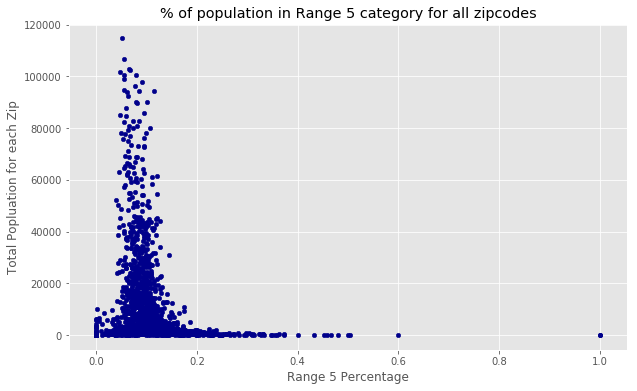

In [7]:
#Let's take a look at the distribution of population % for Range5, to get a sense of what it looks like across all zipcodes in NYC
df_pop_data_2.plot(kind='scatter', x='R5PCT', y='Total Pop', figsize=(10, 6), color='darkblue')

plt.title('% of population in Range 5 category for all zipcodes')
plt.xlabel('Range 5 Percentage')
plt.ylabel('Total Popluation for each Zip')

plt.show()

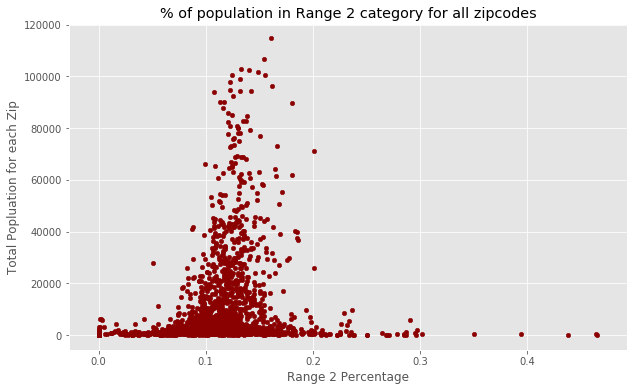

In [8]:
#now let's do the same plot chart, but for a much younger age category for contrasting purposes
df_pop_data_2.plot(kind='scatter', x='R2PCT', y='Total Pop', figsize=(10, 6), color='darkred')

plt.title('% of population in Range 2 category for all zipcodes')
plt.xlabel('Range 2 Percentage')
plt.ylabel('Total Popluation for each Zip')

plt.show()

#### Key Reference: Odds of CBD usage by demographics (age)
Now that we have our data loaded & divided into the appropriate age ranges, let's capture a few key references and explain methodology

Article that shows the odds of usage of CBD for medical usage, by age:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6043845/

#### Methodology to apply probability to neighborhood analysis

Total population per zipcode of course will have a significant influence on the potential demand for CBD products.  However, since the odds of usage of CBD to treat medical conditions are higher with age, we might expect to see neighborhoods with older populations as having high potential too.  We'll need to understand if the proportional mix of age ranges in the neighborhood influences potential demand.

So we want an analysis of population by Manhattan neighborhood revenue potential as follows:

Weight population by the Odds Ratio, we'll be able to come up with a number (when we multiply first, then sum across age ranges) that shows the potential CBD usage for each neighborhood.  Those neighborhoods with the highest # are the ones that have the most potential.
 
**Net Result: a "usage potential by neighborhood, based on population composition of the neighborhood"**
 

Referencing Table 2 in the article linked above gives us the likelihood that a person in a certain age range will use CBD for medical purposes:


| Age | Health Usage | Medical | Odds Ratio | 
| --- | --- | --- | --- |
| ≤24   |72  |(52.17)| 66 (47.83)  |  1.00 (reference)|
| 25–34 |153 (52.40) | 139 (47.60) | 0.99 (0.66–1.49) |
| 25–44	|170 (42.50) | 230 (57.50) | 1.48 (1.00–2.18) |
| 45–54 |150 (37.13) | 254 (62.87) | 1.85 (1.30–2.73) |
| 55–64 |180 (33.83) | 352 (66.17) | 2.13 (1.50–3.12) |
| 65–74 |98 (28.91)  | 241 (71.09) | 2.68 (1.80–4.04) |
| ≥75   |19 (25.68)  | 55 (74.32)  | 3.16 (1.70–5.86) |
 

In [9]:
#create a dataframe capturing the odds of CBD usage by age range, for medical purposes
df_odds=pd.DataFrame(
    {
        "Range":['Range1', 'Range2', 'Range3', 'Range4', 'Range5', 'Range6'],
        "Odds": [.99,1.48,1.85,2.13,2.68,3.16]
    }
)
df_odds


,Range,Odds
0,Range1,0.99
1,Range2,1.48
2,Range3,1.85
3,Range4,2.13
4,Range5,2.68
5,Range6,3.16


In [11]:
#Now we will create a "usage potential" for each zipcode, by multiplying the age range in pop_data_2 by the corresponding odds of usage, and storing it in pop_data_3.
#We'll preface each usage potential column name with "UP", and will copy over the range population percentage for reference, as well as total population

df_pop_data_3=pd.DataFrame()
df_pop_data_3['zip']=df_pop_data_2['zip']
df_pop_data_3['UP_Range1']=df_pop_data_2['Range1']*.99
df_pop_data_3['UP_Range2']=df_pop_data_2['Range2']*1.48
df_pop_data_3['UP_Range3']=df_pop_data_2['Range3']*1.85
df_pop_data_3['UP_Range4']=df_pop_data_2['Range4']*2.13
df_pop_data_3['UP_Range5']=df_pop_data_2['Range5']*2.68
df_pop_data_3['UP_Range6']=df_pop_data_2['Range6']*3.16
df_pop_data_3['R1PCT'] = df_pop_data_2['R1PCT']
df_pop_data_3['R2PCT'] = df_pop_data_2['R2PCT']
df_pop_data_3['R3PCT'] = df_pop_data_2['R3PCT']
df_pop_data_3['R4PCT'] = df_pop_data_2['R4PCT']
df_pop_data_3['R5PCT'] = df_pop_data_2['R5PCT']
df_pop_data_3['R6PCT'] = df_pop_data_2['R6PCT']
df_pop_data_3['Total Pop'] = df_pop_data_2['Total Pop']

df_pop_data_3.head()

,zip,UP_Range1,UP_Range2,UP_Range3,UP_Range4,UP_Range5,UP_Range6,R1PCT,R2PCT,R3PCT,R4PCT,R5PCT,R6PCT,Total Pop
0,10001,5625.18,5187.40,5394.60,5932.05,4389.84,4149.08,0.237274,0.146365,0.121769,0.116298,0.068401,0.054829,23947
1,10002,14458.95,15004.24,19610.00,20997.54,20767.32,25242.08,0.187424,0.130099,0.136028,0.126506,0.099442,0.102509,77925
2,10003,14245.11,12038.32,8896.65,11987.64,9648.00,8781.64,0.261452,0.147797,0.087381,0.102262,0.065413,0.050495,55035
3,10004,857.34,898.36,745.55,713.55,439.52,107.44,0.289632,0.203010,0.134783,0.112040,0.054849,0.011371,2990
4,10005,3279.87,2939.28,1184.00,607.05,367.16,132.72,0.381682,0.228802,0.073733,0.032834,0.015783,0.004839,8680


In [12]:
#now that I have "UP"  (usage potential) for each age range by zipcode, let's create a total column, containing the sum of UP across all Ranges, by zipcode
#Let's also sort the dataframe so that those zipcodes with the highest Total_UP go to the top

df_pop_data_3['Total_UP']=df_pop_data_3['UP_Range1']+df_pop_data_3['UP_Range2']+df_pop_data_3['UP_Range3']+df_pop_data_3['UP_Range4']+df_pop_data_3['UP_Range5']+df_pop_data_3['UP_Range6']
df_pop_data_3.sort_values(by='Total_UP', ascending=False, inplace = True)

df_pop_data_3.head()

,zip,UP_Range1,UP_Range2,UP_Range3,UP_Range4,UP_Range5,UP_Range6,R1PCT,R2PCT,R3PCT,R4PCT,R5PCT,R6PCT,Total Pop,Total_UP
22,10025,16780.50,18400.84,22951.10,26529.15,29027.08,23156.48,0.179589,0.131731,0.131445,0.131964,0.114757,0.077642,94382,136845.15
298,11234,12408.66,17669.72,25104.50,30028.74,23986.00,21244.68,0.128237,0.122149,0.138836,0.144238,0.091569,0.068784,97741,130442.30
279,11214,14672.79,19780.20,24185.05,25033.89,21340.84,23045.88,0.157197,0.141754,0.138657,0.124657,0.084458,0.077352,94283,128058.65
330,11385,18602.10,24277.92,27170.95,26431.17,15669.96,15626.20,0.176270,0.153887,0.137779,0.116409,0.054851,0.046389,106598,127778.30
324,11373,16472.61,23123.52,24053.70,26369.40,19960.64,17095.60,0.172688,0.162154,0.134941,0.128486,0.077299,0.056148,96353,127075.47


In [13]:
#reset index in place
df_pop_data_3.reset_index(drop=True, inplace=True)
df_pop_data_3.head()

,zip,UP_Range1,UP_Range2,UP_Range3,UP_Range4,UP_Range5,UP_Range6,R1PCT,R2PCT,R3PCT,R4PCT,R5PCT,R6PCT,Total Pop,Total_UP
0,10025,16780.50,18400.84,22951.10,26529.15,29027.08,23156.48,0.179589,0.131731,0.131445,0.131964,0.114757,0.077642,94382,136845.15
1,11234,12408.66,17669.72,25104.50,30028.74,23986.00,21244.68,0.128237,0.122149,0.138836,0.144238,0.091569,0.068784,97741,130442.30
2,11214,14672.79,19780.20,24185.05,25033.89,21340.84,23045.88,0.157197,0.141754,0.138657,0.124657,0.084458,0.077352,94283,128058.65
3,11385,18602.10,24277.92,27170.95,26431.17,15669.96,15626.20,0.176270,0.153887,0.137779,0.116409,0.054851,0.046389,106598,127778.30
4,11373,16472.61,23123.52,24053.70,26369.40,19960.64,17095.60,0.172688,0.162154,0.134941,0.128486,0.077299,0.056148,96353,127075.47


In [14]:
#Load NY Manhattan zipcode information, which we will use to reduce the # of rows in our dataframe to show only those zipcodes in Manhattan
body = client_2db08ba9a539447bac4d2169bcd11a6f.get_object(Bucket='adscweek5project-donotdelete-pr-8s2szxgonfbsvj',Key='NYZIPTONEIGHCSV.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
df_neigh_zip = pd.read_csv(body)
df_neigh_zip.head()


,Borough,Neighborhood,Zipcode
0,Manhattan,Central Harlem,10026
1,Manhattan,Central Harlem,10027
2,Manhattan,Central Harlem,10030
3,Manhattan,Central Harlem,10037
4,Manhattan,Central Harlem,10039


In [15]:
#We'll now create a new dataframe by merging the manhattan zipcode list with the full NYC dataframe, resulting in only Manhattan NYC zipcodes

df_total_UP_neigh = pd.DataFrame()
df_total_UP_neigh = pd.merge(df_neigh_zip, df_pop_data_3, how='inner', left_on='Zipcode', right_on='zip')
df_total_UP_neigh.sort_values(by='Total_UP', ascending=False, inplace = True)
df_total_UP_neigh.reset_index(drop=True, inplace=True)
df_total_UP_neigh.head()

#below is the full dataframe of all manhattan neighborhoods, sorted by total usage potential

,Borough,Neighborhood,Zipcode,zip,UP_Range1,UP_Range2,UP_Range3,UP_Range4,UP_Range5,UP_Range6,R1PCT,R2PCT,R3PCT,R4PCT,R5PCT,R6PCT,Total Pop,Total_UP
0,Manhattan,Upper West Side,10025,10025,16780.50,18400.84,22951.10,26529.15,29027.08,23156.48,0.179589,0.131731,0.131445,0.131964,0.114757,0.077642,94382,136845.15
1,Manhattan,Lower East Side,10002,10002,14458.95,15004.24,19610.00,20997.54,20767.32,25242.08,0.187424,0.130099,0.136028,0.126506,0.099442,0.102509,77925,116080.13
2,Manhattan,East Harlem,10029,10029,15805.35,15424.56,16951.55,19376.61,14115.56,16637.40,0.197425,0.128880,0.113311,0.112495,0.065132,0.065108,80866,98311.03
3,Manhattan,Upper West Side,10023,10023,10829.61,15084.16,15136.70,16194.39,19719.44,17275.72,0.177829,0.165686,0.133010,0.123598,0.119615,0.088874,61514,94240.02
4,Manhattan,Upper East Side,10128,10128,14786.64,13044.72,15453.05,14396.67,15801.28,16153.92,0.238050,0.140478,0.133130,0.107725,0.093971,0.081475,62743,89636.28


In [16]:
#Since we're only interested in those zipcodes with the highest potential # of usage, extract only the top 5 zipcodes into a new dataframe
#also, we'll drop the second zipcode column, as it is redundant
top_5_zip=df_total_UP_neigh.head()
top_5_zip.drop(['zip'], axis=1, inplace = True)
top_5_zip

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Borough,Neighborhood,Zipcode,UP_Range1,UP_Range2,UP_Range3,UP_Range4,UP_Range5,UP_Range6,R1PCT,R2PCT,R3PCT,R4PCT,R5PCT,R6PCT,Total Pop,Total_UP
0,Manhattan,Upper West Side,10025,16780.50,18400.84,22951.10,26529.15,29027.08,23156.48,0.179589,0.131731,0.131445,0.131964,0.114757,0.077642,94382,136845.15
1,Manhattan,Lower East Side,10002,14458.95,15004.24,19610.00,20997.54,20767.32,25242.08,0.187424,0.130099,0.136028,0.126506,0.099442,0.102509,77925,116080.13
2,Manhattan,East Harlem,10029,15805.35,15424.56,16951.55,19376.61,14115.56,16637.40,0.197425,0.128880,0.113311,0.112495,0.065132,0.065108,80866,98311.03
3,Manhattan,Upper West Side,10023,10829.61,15084.16,15136.70,16194.39,19719.44,17275.72,0.177829,0.165686,0.133010,0.123598,0.119615,0.088874,61514,94240.02
4,Manhattan,Upper East Side,10128,14786.64,13044.72,15453.05,14396.67,15801.28,16153.92,0.238050,0.140478,0.133130,0.107725,0.093971,0.081475,62743,89636.28


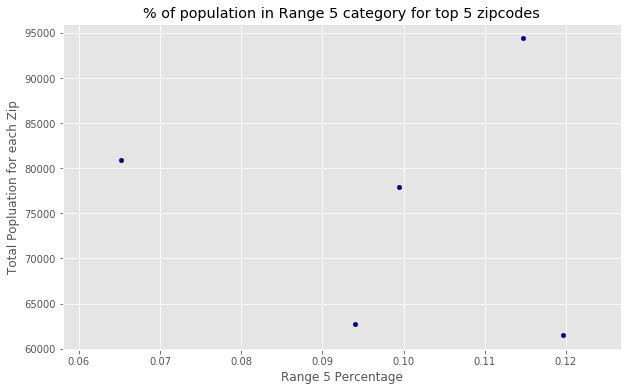

In [82]:
#in this cell, we'll do the same histogram as we did for all NYC zipcodes, but only for the top 5 in top_5_zip dataframe, for compare/contrast purposess
import matplotlib.patches as patches

top_5_zip.plot(kind='scatter', x='R5PCT', y='Total Pop', figsize=(10, 6), color='darkblue')

plt.title('% of population in Range 5 category for top 5 zipcodes')
plt.xlabel('Range 5 Percentage')
plt.ylabel('Total Popluation for each Zip')

#add loop to put zipcodes next to each dot???


plt.show()

In [22]:
#Let's build a simpler dataframe for the purposes of making a bar chart
top_5_bar_chartdata= pd.DataFrame()
top_5_bar_chartdata['Zipcode'] = top_5_zip['Zipcode']
top_5_bar_chartdata['UP_Range1'] = top_5_zip['UP_Range1']
top_5_bar_chartdata['UP_Range2'] = top_5_zip['UP_Range2']
top_5_bar_chartdata['UP_Range3'] = top_5_zip['UP_Range3']
top_5_bar_chartdata['UP_Range4'] = top_5_zip['UP_Range4']
top_5_bar_chartdata['UP_Range5'] = top_5_zip['UP_Range5']
top_5_bar_chartdata['UP_Range6'] = top_5_zip['UP_Range6']

#reset index
top_5_bar_chartdata.set_index('Zipcode', inplace = True)
top_5_bar_chartdata

,UP_Range1,UP_Range2,UP_Range3,UP_Range4,UP_Range5,UP_Range6
Zipcode,,,,,,
10025,16780.50,18400.84,22951.10,26529.15,29027.08,23156.48
10002,14458.95,15004.24,19610.00,20997.54,20767.32,25242.08
10029,15805.35,15424.56,16951.55,19376.61,14115.56,16637.40
10023,10829.61,15084.16,15136.70,16194.39,19719.44,17275.72
10128,14786.64,13044.72,15453.05,14396.67,15801.28,16153.92


[]

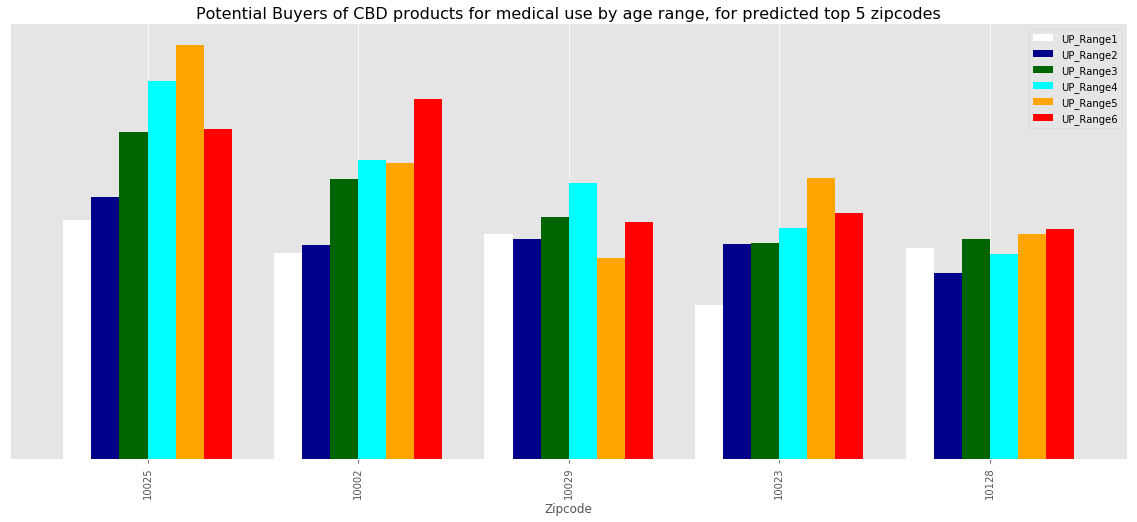

In [23]:
#We'll now build a bar chart of the usage potential by age range within our top 5 zipcodes, for illustration purposes
import matplotlib.patches as patches

ax = top_5_bar_chartdata.plot(kind='bar', figsize=(20, 8), width=.8, color=('white','darkblue','darkgreen','cyan', 'orange', 'red'), edgecolor=None)

ax.set_title('Potential Buyers of CBD products for medical use by age range, for predicted top 5 zipcodes', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])


### Some Observations from the Data

The above barchart shows us that Zip 10025 and Zip 10023 (both of which are in the same neighborhood) have a heavy dose of Range 5 and Range 6 populations;  this older-population-bent combined with the usage likelihood is what is making these top areas to consider setting up a CBD retail store.

It also implies that whatever retail format is decided upon, it should be friendly and accessible to more elderly patients who may have challenges walking in small spaces, have questions & want service, etc

In [38]:
#Now that I have the top 5 neighborhoods (via zipcode), I need to pull foursquare information by zipcode to get pharmacy density

#setting zipcodes and long/lat combinations into variables, for ease of pulling data from foursquare
Zip1 = 10025
Zip1_Lat=-73.9794548
Zip1_Long = 40.7993071

Zip2 = 10002
Zip2_Lat = -73.9935937
Zip2_Long = 40.7157091

Zip3 = 10029
Zip3_Lat = -73.9554803
Zip3_Long = 40.7915976

Zip4 = 10023
Zip4_Lat = -73.9904623
Zip4_Long = 40.7765602

Zip5 = 10128
Zip5_Lat = -73.9636288
Zip5_Long = 40.783285

search_query = 'Pharmacy'
radius = 1000
LIMIT= 100

In [39]:
#assemble url for zip1 and request information for zip1
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, Zip1_Long, Zip1_Lat, VERSION, search_query, radius, LIMIT)

print('URL is: \n')
url


URL is: 



'https://api.foursquare.com/v2/venues/search?client_id=1FP2JJJAAAWLVYLKBTDOIFZYME112E05NE3KQ55EAHEJ0C4S&client_secret=V1GONSLAZZEA3VEFTDYDRWUU11TPCXEEHU2Z0TXVILYD3RFN&ll=40.7993071,-73.9794548&v=20180604&query=Pharmacy&radius=1000&limit=100'

In [40]:
#call API to foursquare to gather information for zip1
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5db0775a2b274a0039bd7e90'},
 'response': {'venues': [{'id': '4af63e6ef964a520910222e3',
    'name': 'CVS pharmacy',
    'location': {'address': '2495 Broadway',
     'crossStreet': 'W 93rd St',
     'lat': 40.79279260064162,
     'lng': -73.97338385679808,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.79279260064162,
       'lng': -73.97338385679808}],
     'distance': 887,
     'postalCode': '10025',
     'cc': 'US',
     'city': 'New York',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['2495 Broadway (W 93rd St)',
      'New York, NY 10025',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d10f951735',
      'name': 'Pharmacy',
      'pluralName': 'Pharmacies',
      'shortName': 'Pharmacy',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/pharmacy_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1571845978',
    'hasPerk': False},
   

In [42]:
# assign relevant part of JSON to venues for zip1
zip1_venues = results['response']['venues']

#declare empty dataframe
zip1_Pharms_df=pd.DataFrame()

# tranform venues into a dataframe and capture # of competitors for zip1
zip1_Pharms_df = json_normalize(zip1_venues)
zip1_count_comp = len(zip1_Pharms_df)
zip1_count_comp

9

In [43]:
#repeat procedure for zip2
#assemble url for zip1 and request information for zip2
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, Zip2_Long, Zip2_Lat, VERSION, search_query, radius, LIMIT)

print('URL is: \n')
url

URL is: 



'https://api.foursquare.com/v2/venues/search?client_id=1FP2JJJAAAWLVYLKBTDOIFZYME112E05NE3KQ55EAHEJ0C4S&client_secret=V1GONSLAZZEA3VEFTDYDRWUU11TPCXEEHU2Z0TXVILYD3RFN&ll=40.7157091,-73.9935937&v=20180604&query=Pharmacy&radius=1000&limit=100'

In [44]:
#call API to foursquare to gather information for zip2
results = requests.get(url).json()


In [45]:
# assign relevant part of JSON to venues for zip2
zip2_venues = results['response']['venues']

#declare empty dataframe
zip2_Pharms_df=pd.DataFrame()

# tranform venues into a dataframe and capture # of competitors for zip1
zip2_Pharms_df = json_normalize(zip2_venues)
zip2_count_comp = len(zip2_Pharms_df)
zip2_count_comp

50

In [46]:
#repeat procedure for zip3
#assemble url for zip1 and request information for zip3
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, Zip3_Long, Zip3_Lat, VERSION, search_query, radius, LIMIT)

print('URL is: \n')
url

URL is: 



'https://api.foursquare.com/v2/venues/search?client_id=1FP2JJJAAAWLVYLKBTDOIFZYME112E05NE3KQ55EAHEJ0C4S&client_secret=V1GONSLAZZEA3VEFTDYDRWUU11TPCXEEHU2Z0TXVILYD3RFN&ll=40.7915976,-73.9554803&v=20180604&query=Pharmacy&radius=1000&limit=100'

In [47]:
#call API to foursquare to gather information for zip3
results = requests.get(url).json()


In [48]:
# assign relevant part of JSON to venues for zip3
zip3_venues = results['response']['venues']

#declare empty dataframe
zip3_Pharms_df=pd.DataFrame()

# tranform venues into a dataframe and capture # of competitors for zip1
zip3_Pharms_df = json_normalize(zip3_venues)
zip3_count_comp = len(zip3_Pharms_df)
zip3_count_comp

31

In [49]:
#repeat procedure for zip4
#assemble url for zip1 and request information for zip4
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, Zip4_Long, Zip4_Lat, VERSION, search_query, radius, LIMIT)

print('URL is: \n')
url

URL is: 



'https://api.foursquare.com/v2/venues/search?client_id=1FP2JJJAAAWLVYLKBTDOIFZYME112E05NE3KQ55EAHEJ0C4S&client_secret=V1GONSLAZZEA3VEFTDYDRWUU11TPCXEEHU2Z0TXVILYD3RFN&ll=40.7765602,-73.9904623&v=20180604&query=Pharmacy&radius=1000&limit=100'

In [50]:
#call API to foursquare to gather information for zip4
results = requests.get(url).json()


In [51]:
# assign relevant part of JSON to venues for zip4
zip4_venues = results['response']['venues']

#declare empty dataframe
zip4_Pharms_df=pd.DataFrame()

# tranform venues into a dataframe and capture # of competitors for zip1
zip4_Pharms_df = json_normalize(zip4_venues)
zip4_count_comp = len(zip4_Pharms_df)
zip4_count_comp

16

In [52]:
#repeat procedure for zip5
#assemble url for zip1 and request information for zip5
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, Zip5_Long, Zip5_Lat, VERSION, search_query, radius, LIMIT)

print('URL is: \n')
url

URL is: 



'https://api.foursquare.com/v2/venues/search?client_id=1FP2JJJAAAWLVYLKBTDOIFZYME112E05NE3KQ55EAHEJ0C4S&client_secret=V1GONSLAZZEA3VEFTDYDRWUU11TPCXEEHU2Z0TXVILYD3RFN&ll=40.783285,-73.9636288&v=20180604&query=Pharmacy&radius=1000&limit=100'

In [53]:
#call API to foursquare to gather information for zip5
results = requests.get(url).json()


In [54]:
# assign relevant part of JSON to venues for zip5
zip5_venues = results['response']['venues']

#declare empty dataframe
zip5_Pharms_df=pd.DataFrame()

# tranform venues into a dataframe and capture # of competitors for zip1
zip5_Pharms_df = json_normalize(zip5_venues)
zip5_count_comp = len(zip5_Pharms_df)
zip5_count_comp

20

In [55]:
#create a dataframe capturing the counts of competitors by zipcode
zip_comp_summary_df=pd.DataFrame(

    {
        "Zipcode":[Zip1, Zip2, Zip3, Zip4, Zip5],
        "Competitors":[zip1_count_comp, zip2_count_comp, zip3_count_comp, zip4_count_comp, zip5_count_comp]
    }
)
zip_comp_summary_df

,Zipcode,Competitors
0,10025,9
1,10002,50
2,10029,31
3,10023,16
4,10128,20


In [56]:
#now that I have # of competitors by zipcode, I should join this information with my ranked list of top5 neighborhoods

top_5_zip_and_comp = pd.merge(top_5_zip, zip_comp_summary_df, how='inner', left_on='Zipcode', right_on='Zipcode')
top_5_zip_and_comp


,Borough,Neighborhood,Zipcode,UP_Range1,UP_Range2,UP_Range3,UP_Range4,UP_Range5,UP_Range6,R1PCT,R2PCT,R3PCT,R4PCT,R5PCT,R6PCT,Total Pop,Total_UP,Competitors
0,Manhattan,Upper West Side,10025,16780.50,18400.84,22951.10,26529.15,29027.08,23156.48,0.179589,0.131731,0.131445,0.131964,0.114757,0.077642,94382,136845.15,9
1,Manhattan,Lower East Side,10002,14458.95,15004.24,19610.00,20997.54,20767.32,25242.08,0.187424,0.130099,0.136028,0.126506,0.099442,0.102509,77925,116080.13,50
2,Manhattan,East Harlem,10029,15805.35,15424.56,16951.55,19376.61,14115.56,16637.40,0.197425,0.128880,0.113311,0.112495,0.065132,0.065108,80866,98311.03,31
3,Manhattan,Upper West Side,10023,10829.61,15084.16,15136.70,16194.39,19719.44,17275.72,0.177829,0.165686,0.133010,0.123598,0.119615,0.088874,61514,94240.02,16
4,Manhattan,Upper East Side,10128,14786.64,13044.72,15453.05,14396.67,15801.28,16153.92,0.238050,0.140478,0.133130,0.107725,0.093971,0.081475,62743,89636.28,20


### Conclusion and Observation

Now that I know that Upper West Side has 2 separate population instances in my top 5, it's my ideal starting place for opening a CBD retail store

It also appears that there are fewer competitors in the Upper West Side (zipcodes 10025 and 10023) making that neighborhood more attractive to open new CBD-retail stores.

In [68]:
#in order to put my top 2 dots on the map, i should extract those 2 entries into a "final" dataframe I'll use for mapping purposes, 
# I'll leveerage lat and long from a post office in each zipcode as a starting place for our dots

top_2_df=pd.DataFrame(

    {
        "Neighborhood":['Upper West Side', 'Upper West Side'],
        "Zipcode":[Zip1, Zip4,],
        "Competitors":[zip1_count_comp, zip4_count_comp,],
        "Lat":['40.7998865', '40.7765595'],
        "Long":['-73.9694428', '-73.9904623']
    }
)
top_2_df.Lat = top_2_df.Lat.astype(float)
top_2_df.Long = top_2_df.Long.astype(float)
top_2_df.head()

,Neighborhood,Zipcode,Competitors,Lat,Long
0,Upper West Side,10025,9,40.799886,-73.969443
1,Upper West Side,10023,16,40.776559,-73.990462


In [73]:
#Here's a map of Manhattan, with blue markers added to indicate the general vicinity of my most desirable location to open a CBD retail store: Upper West Side
NYC_map = folium.Map()
NYC_map = folium.Map(location=[Zip1_Long, Zip1_Lat], zoom_start=14)

# add markers to map
for lat, lng, neighborhood in zip(top_2_df['Lat'], top_2_df['Long'], top_2_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(NYC_map)  
# display map
NYC_map


In [75]:
#Let's create a single competitor table for the Upper West side, and use this table to add red markers to the map so we can see competitor locations

Upper_West_df = pd.DataFrame()
Upper_West_df = pd.concat([zip1_Pharms_df, zip4_Pharms_df], ignore_index = True)
Upper_West_df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId
0,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",False,4af63e6ef964a520910222e3,2495 Broadway,US,New York,United States,W 93rd St,887,"[2495 Broadway (W 93rd St), New York, NY 10025...","[{'label': 'display', 'lat': 40.79279260064162...",40.792793,-73.973384,NaN,10025,NY,CVS pharmacy,v-1571845978
1,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",False,4b251728f964a520266c24e3,743 Amsterdam Ave,US,New York,United States,W. 96th St.,973,"[743 Amsterdam Ave (W. 96th St.), New York, NY...","[{'label': 'display', 'lat': 40.79406433780361...",40.794064,-73.970205,NaN,10025,NY,CVS pharmacy,v-1571845978
2,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",False,4bc78a5f8b7c9c7449a736cf,2721 Broadway,US,New York,United States,104th,940,"[2721 Broadway (104th), New York, NY 10025, Un...","[{'label': 'display', 'lat': 40.79977024421886...",40.799770,-73.968309,NaN,10025,NY,Suba Pharmacy,v-1571845978
3,"[{'id': '5745c2e4498e11e7bccabdbd', 'name': 'D...",False,579fc564498ed3f96fddb38f,2578 Broadway,US,New York,United States,NaN,816,"[2578 Broadway, New York, NY 10025, United Sta...","[{'label': 'display', 'lat': 40.795473, 'lng':...",40.795473,-73.971197,NaN,10025,NY,Value City Pharmacy,v-1571845978
4,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",False,5244b92f11d25b187552d952,NaN,US,New York,United States,NaN,1068,"[New York, NY, United States]","[{'label': 'display', 'lat': 40.791367, 'lng':...",40.791367,-73.972336,NaN,NaN,NY,Peter's Pharmacy,v-1571845978


In [78]:
#Let's now create a Folium Map with the competitors on it AND the blue markers based on zipcode for where we'd want to further investigate opening a CBD retail store
#Here's a map of Manhattan, with blue markers added to indicate the general vicinity of my most desirable location to open a CBD retail store: Upper West Side
NYC_map = folium.Map()
NYC_map = folium.Map(location=[Zip1_Long, Zip1_Lat], zoom_start=14)

# add markers to show the top 2 CBD retail general vicinity based on zipcode
for lat, lng, neighborhood in zip(top_2_df['Lat'], top_2_df['Long'], top_2_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(NYC_map)  

# add markers to show the competitors (pharmacies) on the map for reference
for lat, lng, distance in zip(Upper_West_df['location.lat'], Upper_West_df['location.lng'], Upper_West_df['location.distance']):
    label = '{}'.format(distance)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(NYC_map)  
    
    
    
    # display map
NYC_map
